## Setup

In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *
from deep_q_learning import *

In [2]:
# Configurations
save_stats = True
save_figs = True
train = True
load = not train

seed = 0

In [3]:
# Configuration paramaters for the whole setup
#seed = 0

env = TictactoeEnv()

gamma = 0.99
lr = 5e-4
epsilon_min = 0.1
epsilon_max = 0.8
num_episodes = 20000
test_freq = 250
num_avg = 1

## Learning from experts

### Question 11: Average reward and average loss during training

************** RUN 1 OF 1 **************


100%|██████████| 20000/20000 [14:54<00:00, 22.37it/s]


M_opt = 0.0
M_rand = 0.902
RUN 1 took 903.4 seconds
epsilon_exploration_Q11 = 0.1 : 	M_opt =  0.0 	M_rand =  0.902


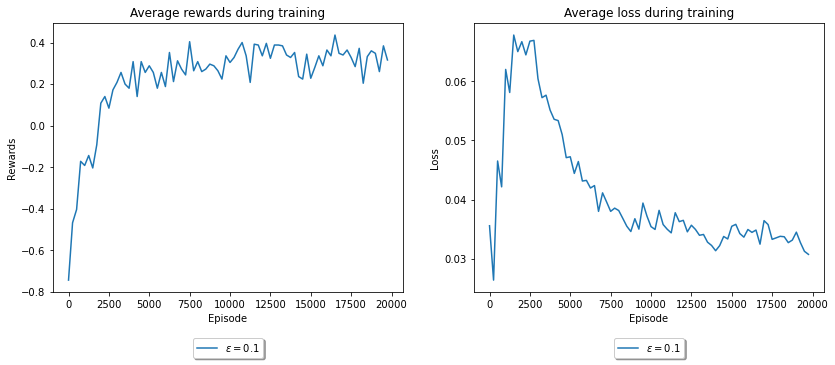

In [4]:
epsilon_exploration = 0.1
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs, keys = ['rewards', 'loss'])

### Question 12: no replay buffer and batch_size = 1

In [ ]:
epsilon_exploration = 0.1
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True,
                                   batch_size=1, max_memory_length=1)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs, keys = ['rewards', 'loss'])

### Question 13: Decreasing exploration for different values of $n^{*}$

In [10]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
num_splits = 3
chunks_list = np.array_split(vec_n_star, num_splits)
print(chunks_list)

[array([1.000e+00, 1.000e+02, 5.000e+02, 7.500e+02, 1.000e+03, 1.279e+03,
       1.635e+03]), array([2091., 2674., 3420., 4373., 5593., 7152., 9146.]), array([11696., 14957., 19127., 24460., 31279., 40000.])]


In [11]:
dqn_params_list = []
for (idx, chunk) in enumerate(chunks_list):
    dqn_params_list.append([])
    for n_star in chunk:
        params = {'env': env,
                  'num_episodes': num_episodes,
                  'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
                  'test_freq': test_freq,
                  'against_opt': True}
        dqn_params_list[idx].append(params)

In [ ]:
chunk_num = 0
if train:
    var_name = 'dqn_n_star_experts_' + str(chunk_num)
    chunk = chunks_list[chunk_num]
    stats_dict_nstar = train_avg(var_name, chunk, dqn_params_list[chunk_num], dqn = True, num_avg=num_avg, save_stats=save_stats)

In [ ]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_dqn_n_star_experts_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_nstar_list.append(to_append)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

dqn_n_star = 1.0 : 	M_opt =  -0.1 	M_rand =  0.836
dqn_n_star = 500.0 : 	M_opt =  -0.114 	M_rand =  0.9
dqn_n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.934
dqn_n_star = 9146.0 : 	M_opt =  -0.212 	M_rand =  0.92
dqn_n_star = 19127.0 : 	M_opt =  -0.314 	M_rand =  0.92
dqn_n_star = 40000 : 	M_opt =  -0.19 	M_rand =  0.802


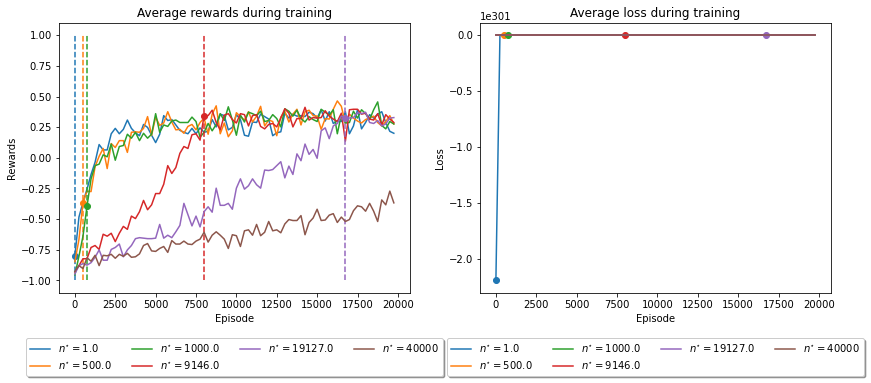

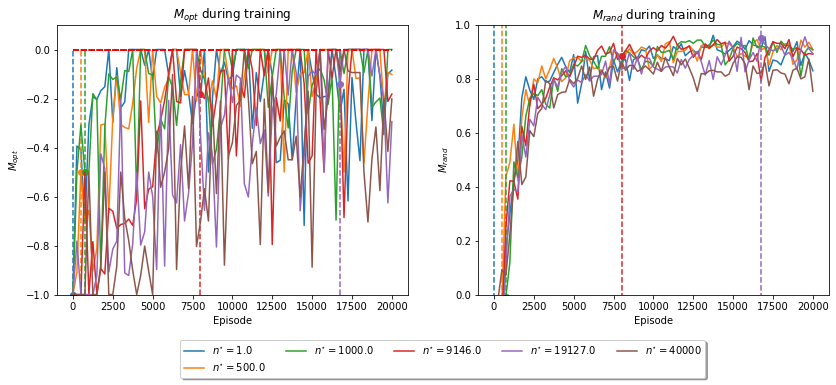

In [18]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 500., 1000., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'dqn_n_star', "n^{\star}", save=save_figs, decaying_exploration=True)

### Question 14: Different values of $\epsilon_{\text{opt}}$

In [ ]:
best_n_star = #########
M = 11
vec_epsilon_opt = np.linspace(0, 1, M)
deep_q_learning_params_list = []
var_name = "epsilon_opt_deep"
for eps in vec_epsilon_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, best_n_star),
              'epsilon_opt': eps,
              'test_freq': test_freq,
              'against_opt': True}
    deep_q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_epsilon_opt_list_deep = train_avg(var_name, vec_epsilon_opt, deep_q_learning_params_list, dqn = True,
                                                      num_avg=num_avg, save_stats=True)

### Question 15: Best values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
# TODO

## Learning by self-practice

In [5]:
n_star = 1
def rule(n):
    return max(epsilon_min, epsilon_max*(1-n/n_star))
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, epsilon_exploration=0.1, num_episodes=num_episodes, self_practice=True, verbose=True, test_freq=test_freq)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'self_practice_test', '\epsilon', save=False, keys = ['rewards', 'loss'])

************** RUN 1 OF 1 **************
Episode  0 :	M_opt =  -1.0 	M_rand =  -0.962


  0%|          | 14/20000 [00:00<02:36, 128.07it/s]

******* Updating target network *******


  1%|▏         | 253/20000 [00:22<3:39:30,  1.50it/s]

Episode  250 :	M_opt =  -1.0 	M_rand =  -0.036


  3%|▎         | 502/20000 [00:48<4:09:14,  1.30it/s]

Episode  500 :	M_opt =  -1.0 	M_rand =  0.244
******* Updating target network *******


  4%|▍         | 752/20000 [01:12<5:22:14,  1.00s/it]

Episode  750 :	M_opt =  -1.0 	M_rand =  0.438


  5%|▌         | 1001/20000 [01:36<4:46:47,  1.10it/s]

Episode  1000 :	M_opt =  -1.0 	M_rand =  0.63
******* Updating target network *******


  6%|▋         | 1252/20000 [02:03<4:24:25,  1.18it/s]

Episode  1250 :	M_opt =  -0.416 	M_rand =  0.666


  8%|▊         | 1502/20000 [02:28<4:18:35,  1.19it/s]

Episode  1500 :	M_opt =  -0.386 	M_rand =  0.698
******* Updating target network *******


  9%|▉         | 1753/20000 [02:52<3:54:29,  1.30it/s]

Episode  1750 :	M_opt =  -1.0 	M_rand =  0.716


 10%|█         | 2002/20000 [03:16<3:58:21,  1.26it/s]

Episode  2000 :	M_opt =  -0.828 	M_rand =  0.722
******* Updating target network *******


 11%|█▏        | 2251/20000 [03:41<5:01:54,  1.02s/it]

Episode  2250 :	M_opt =  -0.408 	M_rand =  0.674


 13%|█▎        | 2503/20000 [04:05<2:54:12,  1.67it/s]

Episode  2500 :	M_opt =  -1.0 	M_rand =  0.756
******* Updating target network *******


 14%|█▍        | 2751/20000 [04:28<4:39:57,  1.03it/s]

Episode  2750 :	M_opt =  -0.92 	M_rand =  0.828


 15%|█▌        | 3001/20000 [04:52<5:05:40,  1.08s/it]

Episode  3000 :	M_opt =  -0.392 	M_rand =  0.754
******* Updating target network *******


 16%|█▋        | 3251/20000 [05:17<4:20:29,  1.07it/s]

Episode  3250 :	M_opt =  -0.41 	M_rand =  0.746


 18%|█▊        | 3502/20000 [05:46<3:48:59,  1.20it/s]

Episode  3500 :	M_opt =  -0.184 	M_rand =  0.728
******* Updating target network *******


 19%|█▉        | 3751/20000 [06:13<4:39:53,  1.03s/it]

Episode  3750 :	M_opt =  -0.382 	M_rand =  0.756


 20%|██        | 4004/20000 [06:38<2:47:56,  1.59it/s]

Episode  4000 :	M_opt =  -0.886 	M_rand =  0.778
******* Updating target network *******


 21%|██▏       | 4253/20000 [07:05<3:22:12,  1.30it/s]

Episode  4250 :	M_opt =  -0.202 	M_rand =  0.758


 23%|██▎       | 4502/20000 [07:33<3:23:41,  1.27it/s]

Episode  4500 :	M_opt =  -0.092 	M_rand =  0.768
******* Updating target network *******


 24%|██▍       | 4751/20000 [07:58<4:56:40,  1.17s/it]

Episode  4750 :	M_opt =  -0.466 	M_rand =  0.85


 25%|██▌       | 5002/20000 [08:24<3:16:25,  1.27it/s]

Episode  5000 :	M_opt =  -0.38 	M_rand =  0.804
******* Updating target network *******


 26%|██▋       | 5252/20000 [08:49<3:14:14,  1.27it/s]

Episode  5250 :	M_opt =  -0.206 	M_rand =  0.756


 28%|██▊       | 5502/20000 [09:15<3:11:06,  1.26it/s]

Episode  5500 :	M_opt =  -0.204 	M_rand =  0.852
******* Updating target network *******


 29%|██▉       | 5752/20000 [09:41<3:18:53,  1.19it/s]

Episode  5750 :	M_opt =  -0.366 	M_rand =  0.78


 30%|███       | 6003/20000 [10:07<2:54:02,  1.34it/s]

Episode  6000 :	M_opt =  -0.3 	M_rand =  0.832
******* Updating target network *******


 31%|███▏      | 6252/20000 [10:34<3:37:42,  1.05it/s]

Episode  6250 :	M_opt =  -0.118 	M_rand =  0.918


 33%|███▎      | 6501/20000 [11:02<4:09:12,  1.11s/it]

Episode  6500 :	M_opt =  -0.22 	M_rand =  0.896
******* Updating target network *******


 34%|███▍      | 6753/20000 [11:28<2:52:53,  1.28it/s]

Episode  6750 :	M_opt =  -0.252 	M_rand =  0.804


 35%|███▌      | 7002/20000 [11:52<2:41:42,  1.34it/s]

Episode  7000 :	M_opt =  -0.554 	M_rand =  0.868
******* Updating target network *******


 36%|███▋      | 7252/20000 [12:18<2:49:50,  1.25it/s]

Episode  7250 :	M_opt =  -0.198 	M_rand =  0.882


 38%|███▊      | 7501/20000 [12:46<3:45:35,  1.08s/it]

Episode  7500 :	M_opt =  -0.3 	M_rand =  0.884
******* Updating target network *******


 39%|███▉      | 7752/20000 [13:13<2:45:36,  1.23it/s]

Episode  7750 :	M_opt =  0.0 	M_rand =  0.878


 40%|████      | 8001/20000 [13:39<4:02:02,  1.21s/it]

Episode  8000 :	M_opt =  -0.5 	M_rand =  0.852
******* Updating target network *******


 41%|████▏     | 8251/20000 [14:05<3:32:50,  1.09s/it]

Episode  8250 :	M_opt =  -0.216 	M_rand =  0.876


 43%|████▎     | 8501/20000 [14:31<3:29:47,  1.09s/it]

Episode  8500 :	M_opt =  -0.234 	M_rand =  0.876
******* Updating target network *******


 44%|████▍     | 8751/20000 [14:58<3:21:32,  1.08s/it]

Episode  8750 :	M_opt =  0.0 	M_rand =  0.89


 45%|████▌     | 9001/20000 [15:26<4:00:57,  1.31s/it]

Episode  9000 :	M_opt =  0.0 	M_rand =  0.902
******* Updating target network *******


 46%|████▋     | 9251/20000 [15:56<4:11:15,  1.40s/it]

Episode  9250 :	M_opt =  -0.096 	M_rand =  0.898


 48%|████▊     | 9501/20000 [16:28<3:46:49,  1.30s/it]

Episode  9500 :	M_opt =  -0.102 	M_rand =  0.836
******* Updating target network *******


 49%|████▉     | 9752/20000 [16:55<2:55:41,  1.03s/it]

Episode  9750 :	M_opt =  -0.202 	M_rand =  0.832


 50%|█████     | 10001/20000 [17:22<3:22:54,  1.22s/it]

Episode  10000 :	M_opt =  -0.194 	M_rand =  0.832
******* Updating target network *******


 51%|█████▏    | 10254/20000 [17:50<2:15:40,  1.20it/s]

Episode  10250 :	M_opt =  -0.204 	M_rand =  0.824


 53%|█████▎    | 10502/20000 [18:18<2:25:00,  1.09it/s]

Episode  10500 :	M_opt =  -0.21 	M_rand =  0.844
******* Updating target network *******


 54%|█████▍    | 10752/20000 [18:45<1:52:37,  1.37it/s]

Episode  10750 :	M_opt =  -0.596 	M_rand =  0.732


 55%|█████▌    | 11001/20000 [19:16<2:59:48,  1.20s/it]

Episode  11000 :	M_opt =  -0.294 	M_rand =  0.762
******* Updating target network *******


 56%|█████▋    | 11251/20000 [19:45<3:23:33,  1.40s/it]

Episode  11250 :	M_opt =  -0.088 	M_rand =  0.808


 58%|█████▊    | 11502/20000 [20:11<1:25:19,  1.66it/s]

Episode  11500 :	M_opt =  -0.212 	M_rand =  0.764
******* Updating target network *******


 59%|█████▉    | 11751/20000 [20:38<2:26:34,  1.07s/it]

Episode  11750 :	M_opt =  -0.104 	M_rand =  0.83


 60%|██████    | 12002/20000 [21:05<1:44:30,  1.28it/s]

Episode  12000 :	M_opt =  -0.108 	M_rand =  0.856
******* Updating target network *******


 61%|██████▏   | 12253/20000 [21:32<1:49:12,  1.18it/s]

Episode  12250 :	M_opt =  -0.094 	M_rand =  0.686


 63%|██████▎   | 12501/20000 [21:58<2:34:03,  1.23s/it]

Episode  12500 :	M_opt =  -0.086 	M_rand =  0.774
******* Updating target network *******


 64%|██████▍   | 12752/20000 [22:24<1:36:57,  1.25it/s]

Episode  12750 :	M_opt =  -0.196 	M_rand =  0.848


 65%|██████▌   | 13001/20000 [22:50<2:19:10,  1.19s/it]

Episode  13000 :	M_opt =  -0.206 	M_rand =  0.866
******* Updating target network *******


 66%|██████▋   | 13253/20000 [23:17<1:41:49,  1.10it/s]

Episode  13250 :	M_opt =  -0.226 	M_rand =  0.786


 68%|██████▊   | 13503/20000 [23:41<1:20:12,  1.35it/s]

Episode  13500 :	M_opt =  -0.592 	M_rand =  0.744
******* Updating target network *******


 69%|██████▉   | 13753/20000 [24:03<1:15:05,  1.39it/s]

Episode  13750 :	M_opt =  -0.104 	M_rand =  0.796


 70%|███████   | 14003/20000 [24:25<1:04:26,  1.55it/s]

Episode  14000 :	M_opt =  -0.108 	M_rand =  0.842
******* Updating target network *******


 71%|███████▏  | 14252/20000 [24:48<1:04:08,  1.49it/s]

Episode  14250 :	M_opt =  -0.782 	M_rand =  0.782


 73%|███████▎  | 14501/20000 [25:11<1:24:19,  1.09it/s]

Episode  14500 :	M_opt =  -0.202 	M_rand =  0.762
******* Updating target network *******


 74%|███████▍  | 14751/20000 [25:37<1:35:52,  1.10s/it]

Episode  14750 :	M_opt =  -0.312 	M_rand =  0.834


 75%|███████▌  | 15003/20000 [26:03<59:27,  1.40it/s]  

Episode  15000 :	M_opt =  -0.188 	M_rand =  0.862
******* Updating target network *******


 76%|███████▋  | 15251/20000 [26:26<1:30:30,  1.14s/it]

Episode  15250 :	M_opt =  -0.816 	M_rand =  0.592


 78%|███████▊  | 15501/20000 [26:50<1:27:06,  1.16s/it]

Episode  15500 :	M_opt =  -0.798 	M_rand =  0.662
******* Updating target network *******


 79%|███████▉  | 15753/20000 [27:18<53:11,  1.33it/s]  

Episode  15750 :	M_opt =  -0.78 	M_rand =  0.762


 80%|████████  | 16002/20000 [27:43<56:45,  1.17it/s]  

Episode  16000 :	M_opt =  -0.808 	M_rand =  0.778
******* Updating target network *******


 81%|████████▏ | 16251/20000 [28:07<1:14:17,  1.19s/it]

Episode  16250 :	M_opt =  -0.302 	M_rand =  0.782


 83%|████████▎ | 16503/20000 [28:34<41:39,  1.40it/s]  

Episode  16500 :	M_opt =  -0.29 	M_rand =  0.738
******* Updating target network *******


 84%|████████▍ | 16752/20000 [29:01<44:42,  1.21it/s]  

Episode  16750 :	M_opt =  -0.386 	M_rand =  0.656


 85%|████████▌ | 17001/20000 [29:27<1:00:19,  1.21s/it]

Episode  17000 :	M_opt =  -0.106 	M_rand =  0.71
******* Updating target network *******


 86%|████████▋ | 17252/20000 [29:51<37:07,  1.23it/s]  

Episode  17250 :	M_opt =  -0.192 	M_rand =  0.84


 88%|████████▊ | 17503/20000 [30:16<29:35,  1.41it/s]

Episode  17500 :	M_opt =  -0.192 	M_rand =  0.848
******* Updating target network *******


 89%|████████▉ | 17752/20000 [30:40<27:54,  1.34it/s]

Episode  17750 :	M_opt =  -0.424 	M_rand =  0.76


 90%|█████████ | 18002/20000 [31:04<28:04,  1.19it/s]

Episode  18000 :	M_opt =  -0.398 	M_rand =  0.778
******* Updating target network *******


 91%|█████████▏| 18252/20000 [31:29<22:44,  1.28it/s]

Episode  18250 :	M_opt =  -0.5 	M_rand =  0.778


 93%|█████████▎| 18501/20000 [31:52<26:21,  1.06s/it]

Episode  18500 :	M_opt =  -0.5 	M_rand =  0.816
******* Updating target network *******


 94%|█████████▍| 18752/20000 [32:16<16:30,  1.26it/s]

Episode  18750 :	M_opt =  -0.5 	M_rand =  0.81


 95%|█████████▌| 19002/20000 [32:41<15:37,  1.06it/s]

Episode  19000 :	M_opt =  -0.5 	M_rand =  0.796
******* Updating target network *******


 96%|█████████▋| 19252/20000 [33:07<09:53,  1.26it/s]

Episode  19250 :	M_opt =  -0.376 	M_rand =  0.808


 98%|█████████▊| 19501/20000 [33:31<09:39,  1.16s/it]

Episode  19500 :	M_opt =  -0.43 	M_rand =  0.728
******* Updating target network *******


 99%|█████████▉| 19751/20000 [33:59<05:08,  1.24s/it]

Episode  19750 :	M_opt =  -0.552 	M_rand =  0.776


100%|██████████| 20000/20000 [34:26<00:00,  9.68it/s]

Episode  20000 :	M_opt =  -0.406 	M_rand =  0.78


M_opt = -0.412
M_rand = 0.72


NameError: name 'epsilon_exploration' is not defined

self_practice_test = 0.1 : 	M_opt =  -0.412 	M_rand =  0.72


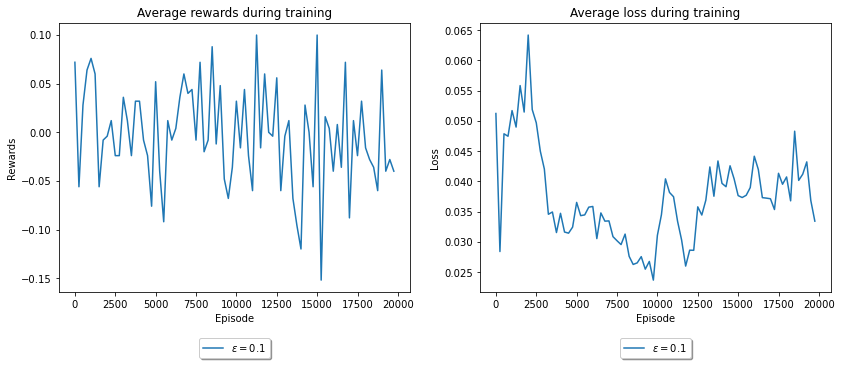

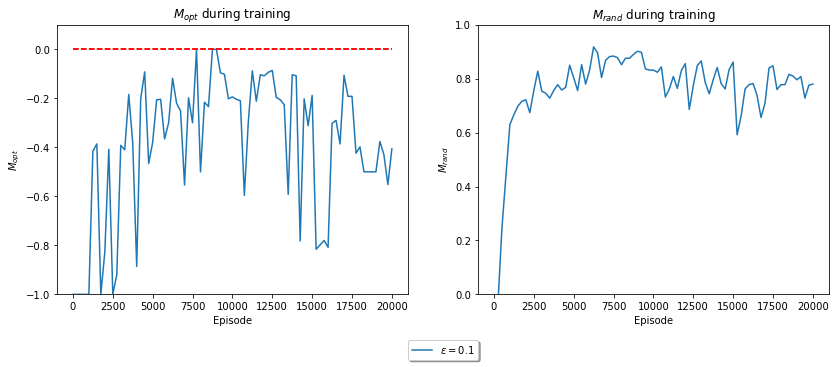

In [8]:
epsilon_exploration = 0.1
stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
stats_dict_list.append(stats_dict)
plot_stats(stats_dict_list, [epsilon_exploration], 'self_practice_test', '\epsilon', save=False)

### Question 16: Different values of the exploration rate $\epsilon$

In [ ]:
M = 10
vec_eps = np.linspace(0, 1, M)
deep_q_learning_params_list = []
var_name = "epsilon_deep_self"
for eps in vec_eps:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': test_freq,
              'self_practice': True}
    deep_q_learning_params_list.append(params)

In [ ]:
if train:
     stats_dict_epsilon_self_list_deep = train_avg(var_name, vec_eps, deep_q_learning_params_list, dqn = True,
                                                        num_avg=num_avg, save_stats=True)

### Question 17: Decreasing exploration for different values of $n^*$

In [ ]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
deep_q_learning_params_list = []
var_name = "n_star_self_deep"
for n_star in vec_n_star:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'self_practice': True}
    deep_q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_nstar_self_list_deep = train_avg(var_name, vec_n_star, deep_q_learning_params_list, dqn = True,
                                                     num_avg=num_avg, save_stats=True)

### Question 18: Best values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
# TODO

### Question 19: Heatmaps of the Q-values in 3 significant states

In [ ]:
# Optimal parameters
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 15000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
model, stats = deep_q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, 
                               verbose=True, against_opt=True)

In [ ]:
grids = np.array([[[1., 0., 0.], [-1., 1., 0.], [0., -1., 0.]]])
print(grids[0])
heatmaps_deep_subplots(grids, model, save=save_figs)